# Iterative Backtesting

This implementation helps testing and optimizing SMA strategy with historical binance data.

In [1]:
api_key = "6ce63f3406fd8ebbff01054a66c25fe3c851c45932088c8ca3131a7005188462"
secret_key = "aa3ea32929252467fa5ffeac5818c95beabfb5dba691ef445e7eaa31ea0d15f6"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

### How open position units (buy or sell) are calculated?

When you have leverage, you just want to spend the corresponding fracon of the ammount passed to function. For example, if you have leverage of 3 and you pass amount = 3000, then you just want to spend 1000 for buying or selling. With this in mind we build the next formulas that must hold true...

$$myAmount=TotalAmount/ Leverage$$

$$AmountForUnits + paidFee = myAmount$$

$$paidFee = (totalAmountBought)*Fee = (AmountForUnits*Leverage)*Fee$$

then, 

$$AmountForUnits + AmountForUnits*Leverage*fee = myAmount$$

$$AmountForUnits = myAmount/( 1 + Leverage*fee )$$

With this, you will spend your corresponding fraction of the money buying the correct units and paying the fee entirely.

Important:
 
$$AmountForUnits*Leverage + fee != myAmount*Leverage$$

In other words, you dont use all the amount you pass to the function to buy or sell units, because you have to pay fees with that money. The money you pay for fees increases with leverage. 


### How close position units (buy or sell) are calculated?

When you close a position, you also have to consider leverage, because when do it, it returns to you your units on "amount" and the profit of ALL the position. In other words, you have to return the units to the broker again. Dont forget to pay the comission of closing. We use the next formulas to calculate everything: 

$$Units = UnleveredUnits*Leverage$$
$$myAssetEntryValue = unleveredUnits * entryPrice$$
$$profit = Units * (currentPrice - entryPrice)$$
$$payFee = abs(Units) * currentPrice * Fee$$ 

Then you consider all this to update your current balance:

$$balance += myAssetEntryValue + profit - payFee

Important: for short positions, units are negative, because you sell them, then the formulas have sense.

# Order Class

This class keeps track of each order calculations

In [276]:
class Order():
    
    def __repr__(self):
        if self.position == 1:
            return "LONG"
        else:
            return "SHORT"
    
    def __init__(self, amount, leverage, expected_entry_price, position, created_at, 
                 fee_maker, fee_taker, use_fee, order_type = "MARKET"):
        self.order_type = order_type
        self.amount = amount
        self.leverage = leverage
        self.amount_to_spend = self.amount/self.leverage #amount to really spend from my balance
        self.expected_entry_price = expected_entry_price
        self.position = position #long (1) or short (-1)
        self.fee_maker = fee_maker #comision for limit order
        self.fee_taker= fee_taker #comision for market order
        self.use_fee = use_fee #True or False
        self.created_at = created_at # creating position datetime
        ########### Open position params ###########
        self.entry_price = None
        self.opening_at = None #opening position datetime
        self.unlev_amount_to_buy_units = None
        self.amount_to_buy_units = None
        self.opening_fee_as_amount = None 
        self.opening_fee_as_units = None
        self.unlev_units = None
        self.units = None
        ########### Close position params ###########
        self.closing_at = None #close position datetime
        self.closing_fee_as_amount = None 
        self.closing_fee_as_units = None
        self.closing_price = None
        
    def open_position(self, date, entry_price):
        self.opening_at = date # open position datetime
        if entry_price is None: 
            self.entry_price = self.expected_entry_price #for limit orders
        else:
            self.entry_price = entry_price #market orders    
        ##################### Works for long and short ##################    
        self.unlev_amount_to_buy_units = self.amount_to_spend/( 1 + self.leverage*self.fee_taker*self.use_fee )
        self.amount_to_buy_units = self.unlev_amount_to_buy_units*self.leverage
        self.opening_fee_as_amount = self.amount_to_buy_units*self.fee_taker*self.use_fee
        self.opening_fee_as_units = self.opening_fee_as_amount/self.entry_price
        self.unlev_units = self.unlev_amount_to_buy_units/self.entry_price
        self.units = self.unlev_units*self.leverage
        if self.position == 1:
            print("{} |  Buying {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        else:
            print("{} |  Selling {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        return self.units, self.opening_fee_as_amount
        
    def get_close_fee(self, price, as_amount= True):
        fee = self.units * self.fee_taker * self.use_fee
        if as_amount: fee*=price
        return fee
    
    def get_PnL(self, price, include_fee = False, as_amount = True):
        #get profit (by default doesnt include fee as Binance)
        PnL = self.position * self.units * (price - self.entry_price)
        fee = self.get_close_fee(price, as_amount= True) * include_fee
        profit = PnL - fee
        if not as_amount: profit/=price
        return profit
    
    def get_position_value(self, price, include_fee = True, as_amount = True):
        #gets the spent money and profits of the position (subtracts closing fee if True)
        profit = self.get_PnL(price = price, include_fee = include_fee, as_amount = True)
        pos_val = self.unlev_amount_to_buy_units + profit
        if not as_amount: pos_val /= price
        return pos_val
    
    def close_position(self, date, price): #helper method for buy and sell instrument methods
        self.closing_at = date
        self.closing_price = price
        self.closing_fee_as_amount = self.get_close_fee(price, as_amount = True)
        self.closing_fee_as_units = self.get_close_fee(price, as_amount = False)
        pos_value = self.get_position_value(price)
        if self.position == -1:
            print("{} |  Buying (closing) {} for {}".format(date, self.units, round(price, 5)))
        else:
            print("{} |  Selling (closing) {} for {}".format(date, self.units, round(price, 5)))  
        return pos_value
    
    def is_open(self):
        return self.closing_at is None
    
    def is_closed(self):
        return not self.is_open()

In [202]:
#initialize the order
from datetime import datetime

leverage = 2
#initialize the order (it makes sense with limit orders because its like submit them)
order = Order(amount = 100000*leverage, #more info of this on sections above
              leverage = leverage, 
              expected_entry_price = 100000, #useful for limit orders, price when order is executed 
              position = -1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = 0.0002, 
              fee_taker = 0.0004, 
              use_fee = True)
#execute the order 
#with market orders we use entry_price = expected_entry_price to simulate execution at the moment
order.open_position(datetime.now(), entry_price = order.expected_entry_price)

2022-08-21 01:47:54.101898 |  Selling 1.9984012789768186 for 100000, leverage 2


(1.9984012789768186, 79.93605115907275)

In [195]:
#get closing fee of position at a certain price
order.get_close_fee(price = 100000, as_amount = True)

79.93605115907275

In [196]:
#prints current PnL of position at a certain price
order.get_PnL(price = 50000, as_amount = True, include_fee = True)

99880.0959232614

In [197]:
#returns all money that you will receive if position is closed (including invested one) at a certain price
order.get_position_value(price = 50000, as_amount = True, include_fee = True)

199800.15987210232

In [192]:
#True if position is open
order.is_open()

True

In [193]:
#closes the position and returns profits at a certain price...
pos_val = order.close_position(datetime.now(), price = 50000)

2022-08-21 01:11:32.249853 |  Buying (closing) 1.9984012789768186 for 50000


In [194]:
#True if position is closed
order.is_closed()

True

# BinanceApi Class
This class helps to keep track of actions made in "account".

In [457]:
class BinanceApi():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.available_balance= amount #keeps unlevered balance (real balance)
        self.open_orders = []
        self.closed_orders= []
        self.trades = 0
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()

    def get_data(self):
        raw = pd.read_csv("5m.csv", parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw = raw[["Close"]].rename(columns={"Close": "price"}) #just use these columns
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None):  
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
    
    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        return date, price
    
    def print_available_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.available_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open long position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = 1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee)
            order.open_position(date = date, entry_price = price)              
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [-1]: #closing short position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
                    
    def sell_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open short position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = -1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee)
            order.open_position(date = date, entry_price = price)              
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [1]: #closing long position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
            
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def get_nav(self, bar):
        if len(self.open_orders) == 0: return self.available_balance
        date, price = self.get_values(bar)
        order = self.open_orders[0]
        pos_value = order.get_position_value(price = price, include_fee = True, as_amount = True)
        return self.available_balance + pos_value

    def get_position(self):
        if len(self.open_orders) == 0:
            return 0
        return self.open_orders[0].position

# Backtest class
keeps strategies for automated trading

In [507]:
class IterativeBacktest(BinanceApi):

    # helper method
    def go_long(self, bar, units = None, amount = None):
        if self.get_position() == -1:
            self.buy_instrument(bar, units = self.open_orders[0].units) # if short position, go neutral first
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None):
        if self.get_position() == 1:
            self.sell_instrument(bar, units = self.open_orders[0].units) # if long position, go neutral first
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            self.sell_instrument(bar, amount = amount) # go short

    def test_sma_strategy(self, SMA_S, SMA_L, leverage = 1,keep_metrics = True):
        
        # nice printout
        stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}".format(self.symbol, SMA_S, SMA_L)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        
        # prepare data
        self.data["SMA_S"] = self.data["price"].rolling(SMA_S).mean()
        self.data["SMA_L"] = self.data["price"].rolling(SMA_L).mean()
        self.data.dropna(inplace = True)
        
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
        self.leverage = leverage
        # sma crossover strategy
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            if self.data["SMA_S"].iloc[bar] > self.data["SMA_L"].iloc[bar]: # signal to go long
                if self.get_position() in [0, -1]:
                    self.go_long(bar, amount = "all") # go long with full amount
            elif self.data["SMA_S"].iloc[bar] < self.data["SMA_L"].iloc[bar]: # signal to go short
                if self.get_position() in [0, 1]:
                    self.go_short(bar, amount = "all") # go short with full amount
            self.calculate_metrics(bar)        
                    
        self.close_final_position(bar+1) # close position at the last bar
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.position )
        self.navs.append( self.get_nav(bar) )
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions
        self.data["NAV"] = self.navs
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        if self.get_position() in [-1]:
            self.buy_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() in [1]:    
            self.sell_instrument(bar, units = self.open_orders[0].units)
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        self.print_available_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, self.trades))
        print(75 * "-")    

### Test strategy

In [508]:
bc = IterativeBacktest(symbol = "BTCUSD", 
                       start = "2022-01-31", 
                       end = "2023-06-30", 
                       amount = 100000, 
                       use_fee= True,
                       fee_maker = 0.0002,
                       fee_taker = 0.0004
                    )

In [509]:
bc.data

,price,returns,Hold Strategy
Date,,,
2022-07-12 11:15:00,19729.8,NaN,NaN
2022-07-12 11:20:00,19713.8,-0.000811,99918.904398
2022-07-12 11:25:00,19772.7,0.002983,100217.437582
2022-07-12 11:30:00,19823.3,0.002556,100473.902422
2022-07-12 11:35:00,19766.9,-0.002849,100188.040426
...,...,...,...
2022-08-16 04:10:00,24550.0,0.002039,124431.063670
2022-08-16 04:15:00,24450.0,-0.004082,123924.216160
2022-08-16 04:20:00,24508.3,0.002382,124219.708259


In [512]:
bc.test_sma_strategy(50, 200, 1, True)

---------------------------------------------------------------------------
Testing SMA strategy | BTCUSD | SMA_S = 50 & SMA_L = 200
---------------------------------------------------------------------------
2022-07-13 |  Selling 5.130732858735619 for 19482.6, leverage 1
2022-07-13 |  Buying (closing) 5.130732858735619 for 19830.9
2022-07-13 |  Buying 4.946474728858771 for 19830.9, leverage 1
2022-07-13 |  Selling (closing) 4.946474728858771 for 19605.6
2022-07-13 |  Selling 4.942519131314701 for 19605.6, leverage 1
2022-07-13 |  Buying (closing) 4.942519131314701 for 19740.0
2022-07-13 |  Buying 4.87129121900348 for 19740.0, leverage 1
2022-07-14 |  Selling (closing) 4.87129121900348 for 19748.5
2022-07-14 |  Selling 4.867395744218191 for 19748.5, leverage 1
2022-07-14 |  Buying (closing) 4.867395744218191 for 20199.8
2022-07-14 |  Buying 4.646097530210663 for 20199.8, leverage 1
2022-07-16 |  Selling (closing) 4.646097530210663 for 20690.8
2022-07-16 |  Selling 4.642382138343241 for

2022-08-02 |  Buying (closing) 2.8101601417193334 for 23949.0
2022-08-02 |  Buying 2.7009187532413788 for 23949.0, leverage 1
2022-08-02 |  Selling (closing) 2.7009187532413788 for 23264.0
2022-08-02 |  Selling 2.6987588821872075 for 23264.0, leverage 1
2022-08-02 |  Buying (closing) 2.6987588821872075 for 23513.1
2022-08-02 |  Buying 2.639441789435064 for 23513.1, leverage 1
2022-08-02 |  Selling (closing) 2.639441789435064 for 23268.9
2022-08-02 |  Selling 2.6373310802871752 for 23268.9, leverage 1
2022-08-03 |  Buying (closing) 2.6373310802871752 for 23588.7
2022-08-03 |  Buying 2.56374026927813 for 23588.7, leverage 1
2022-08-04 |  Selling (closing) 2.56374026927813 for 23844.0
2022-08-04 |  Selling 2.5616900971315664 for 23844.0, leverage 1
2022-08-05 |  Buying (closing) 2.5616900971315664 for 23148.3
2022-08-05 |  Buying 2.713558285650516 for 23148.3, leverage 1
2022-08-05 |  Selling (closing) 2.713558285650516 for 23018.0
2022-08-05 |  Selling 2.7113883070134506 for 23018.0, lev

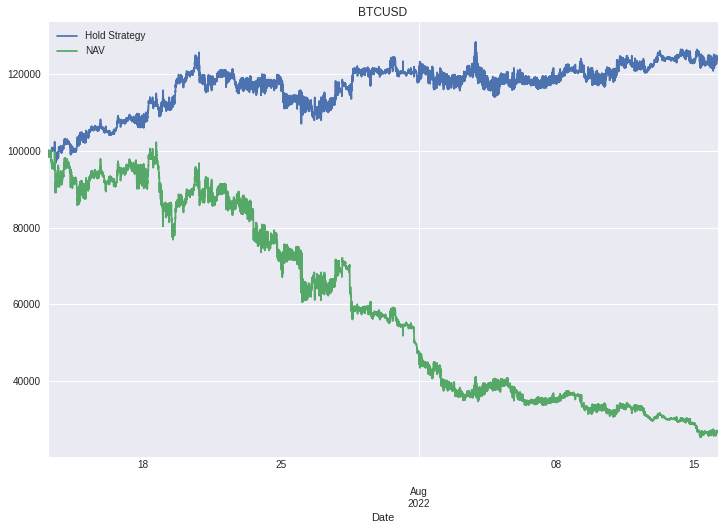

In [511]:
bc.plot_data(["Hold Strategy", "NAV"])

In [505]:
len(bc.closed_orders)

90

### Testing buying and selling instrument by amount

In [459]:
#put fees false to make calculations simpler
bc = IterativeBacktest(symbol = "BTCUSD", 
                       start = "2022-01-31", 
                       end = "2023-06-30", 
                       amount = 100000, 
                       use_fee= True,
                       fee_maker = 0.0002,
                       fee_taker = 0.0004
                    )

In [460]:
#prints first period price
bc.data.price[0]

19729.8

In [461]:
#make the next period double of that to test it easier
bc.data.price[1] = bc.data.price[0]*2
bc.data.price[1]

9864.9

In [462]:
#put the leverage that you want
bc.leverage = 2

In [463]:
#available balance as declared on bc
bc.available_balance

100000

In [464]:
#nav = Net Asset Value. Its the sum of your balance and current position. You dont have positions right now
#must be same as bc.available_balance
bc.get_nav(0)

100000

In [465]:
#max amount of money you can spend is your available_balance times leverage
#Important: to spend a certain amount you should do:
#amount_for_function = amount_to_spend*leverage
max_amount = bc.available_balance*bc.leverage
max_amount

200000

In [466]:
#buy max amount of units permitted at certain price
bc.buy_instrument(bar = 0, amount = abs(max_amount))

2022-07-12 |  Selling 10.128847119468109 for 19729.8, leverage 2


In [467]:
#must be 0, because you spent all your money buying units
bc.available_balance

0.0

In [468]:
#opened positions are saved on this array
bc.open_orders

[SHORT]

In [469]:
#you can get again the previous bought amount multiplying your units by buy price
# if fees are true, it will be a little less because opening position fee was paid
order = bc.open_orders[0]
amount = order.units*bc.data.price[0]
amount

199840.12789768187

In [470]:
#nav at time of buy, it must be the same as before buying
#if fee is True it will be less than cell above, because this takes into account the closing position fee
bc.get_nav(0)

99840.12789768186

In [471]:
#nav if we sell at the next period, it must consider leverage profits (and fees)
bc.get_nav(1)

199800.15987210232

In [472]:
#to sell all the units bought using "amount" you need to consider this: 
#The amount that you have changes when price moves, because you have units of the instrument!!!!!
#the current amount to sell is the total of units you have multiplied by the current price.
available_amount = bc.open_orders[0].units*bc.data.price[1]
available_amount

99920.06394884094

In [473]:
#MUST VERIFY THAT SELLS ALL BOUGHT UNITS
bc.sell_instrument(1, amount = abs(available_amount) )

2022-07-12 |  Buying (closing) 10.128847119468109 for 9864.9


In [474]:
#must be same as predicted in bc.get_nav(1)
bc.available_balance

199800.15987210232

In [475]:
#must be same as bc.available_balance (2 cells above) because now you dont have open positions
bc.get_nav(1)

199800.15987210232

In [476]:
#must have now no open orders
bc.open_orders

[]

In [477]:
#closed orders are saved on this array
bc.closed_orders

[SHORT]

In [478]:
#you can see the opening paid fee of the order
bc.closed_orders[0].opening_fee_as_amount

79.93605115907275

In [479]:
#you can see the closing paid fee of the order
bc.closed_orders[0].closing_fee_as_amount

39.96802557953638